**Imports**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import pickle
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix ,classification_report,precision_score, recall_score , f1_score, accuracy_score 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
import warnings
warnings.filterwarnings('ignore')

Data analysis

In [2]:
data = pd.read_csv('stroke.csv')

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
na_count = data.isna().sum().sum()
print(f"Count of 'NaN': {na_count}")

Count of 'NaN': 201


In [4]:
data_cleaned = data.dropna()

In [5]:
data_cleaned.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [6]:
data_cleaned.to_csv('stroke_cleaned.csv', index=False)

In [7]:
invalid_gender_rows = data_cleaned[~data_cleaned['gender'].isin(['Male', 'Female'])]
print("Rows with invalid gender values:")
invalid_gender_rows.head()

Rows with invalid gender values:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [8]:
invalid_work_rows = data_cleaned[~data_cleaned['work_type'].isin(['children', 'Self-employed', 'Govt_job', 'Private'])]
print("Rows with invalid work_type values:")
invalid_work_rows.head()

Rows with invalid work_type values:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
959,56986,Male,17.0,0,0,No,Never_worked,Urban,113.25,23.4,never smoked,0


Define the mappings

In [9]:
married_map = {'No': 0, 'Yes': 1}
gender_map = {'Male': 0, 'Female': 1, 'Other': 2}
work_map = {'children': 0, 'Self-employed': 1, 'Govt_job': 2, 'Private': 3, 'Never_worked': 4}
residence_map = {'Rural': 0, 'Urban': 1}
smoking_map = {'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3}

Apply mappings

In [10]:
data_cleaned['ever_married'] = data_cleaned['ever_married'].map(married_map).fillna(-1).astype(int)
data_cleaned['gender'] = data_cleaned['gender'].map(gender_map).fillna(-1).astype(int)
data_cleaned['work_type'] = data_cleaned['work_type'].map(work_map).fillna(-1).astype(int)
data_cleaned['Residence_type'] = data_cleaned['Residence_type'].map(residence_map).fillna(-1).astype(int)
data_cleaned['smoking_status'] = data_cleaned['smoking_status'].map(smoking_map).fillna(-1).astype(int)

In [11]:
data_cleaned.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,3,1,228.69,36.6,2,1
2,31112,0,80.0,0,1,1,3,0,105.92,32.5,1,1
3,60182,1,49.0,0,0,1,3,1,171.23,34.4,3,1
4,1665,1,79.0,1,0,1,1,0,174.12,24.0,1,1
5,56669,0,81.0,0,0,1,3,1,186.21,29.0,2,1


In [12]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   int64  
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   int64  
 6   work_type          4909 non-null   int64  
 7   Residence_type     4909 non-null   int64  
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   int64  
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 498.6 KB


In [13]:
data_cleaned.describe()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,0.590548,42.865374,0.091872,0.049501,0.652679,2.150336,0.507232,105.305150,28.893237,1.168670,0.042575
std,20995.098457,0.492197,22.555115,0.288875,0.216934,0.476167,1.128198,0.499999,44.424341,7.854067,1.022201,0.201917
min,77.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000
25%,18605.000000,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,77.070000,23.500000,0.000000,0.000000
50%,37608.000000,1.000000,44.000000,0.000000,0.000000,1.000000,3.000000,1.000000,91.680000,28.100000,1.000000,0.000000
75%,55220.000000,1.000000,60.000000,0.000000,0.000000,1.000000,3.000000,1.000000,113.570000,33.100000,2.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000


In [14]:
data_cleaned.drop(columns=['id'], inplace=True)

In [15]:
data_cleaned.describe().columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [16]:
data = data_cleaned

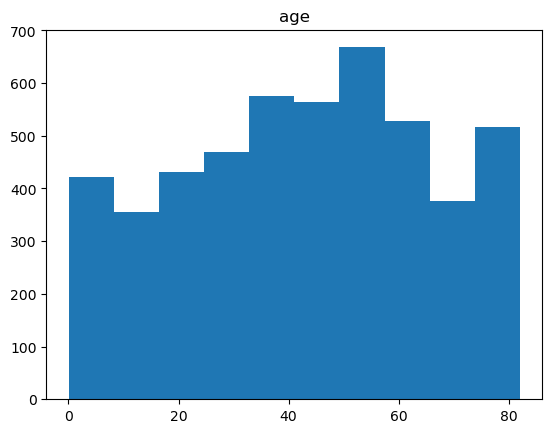

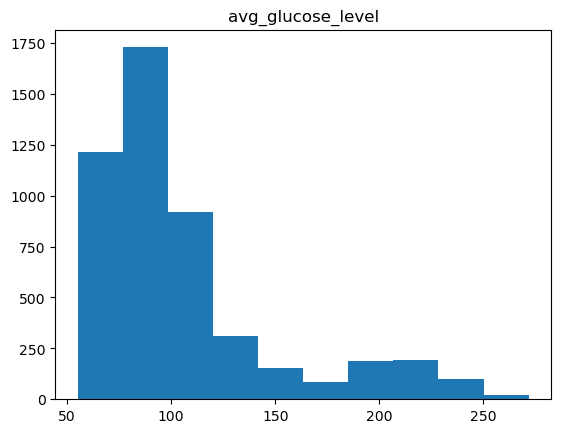

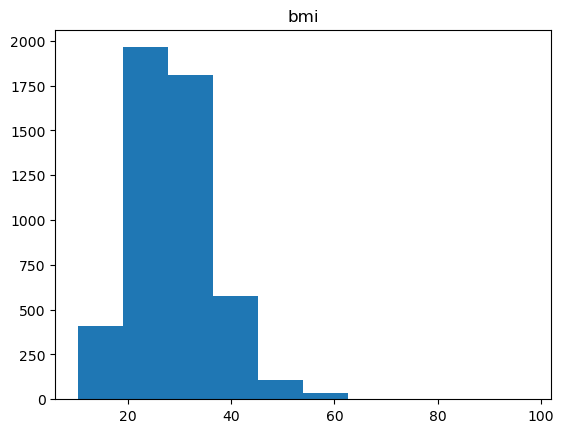

,age,avg_glucose_level,bmi
stroke,,,
0,41.760451,104.003736,28.823064
1,67.712919,134.571388,30.471292


In [17]:
data_num = data[['age', 'avg_glucose_level', 'bmi']]
data_cat =data[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]

for i in data_num.columns:
    plt.hist(data_num[i])
    plt.title(i)
    plt.show()

pd.pivot_table(data, index='stroke', values=['age', 'avg_glucose_level', 'bmi'])

Graphical Presentation

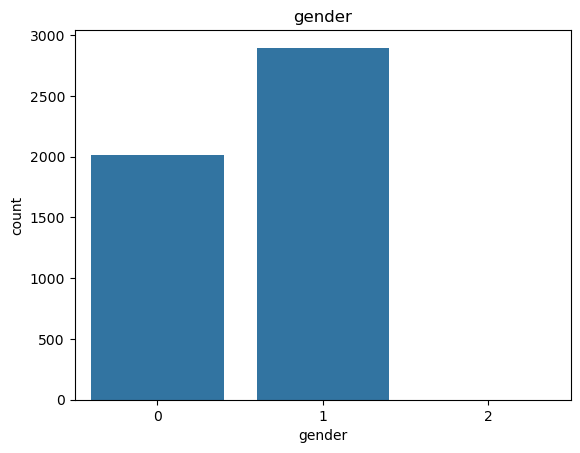

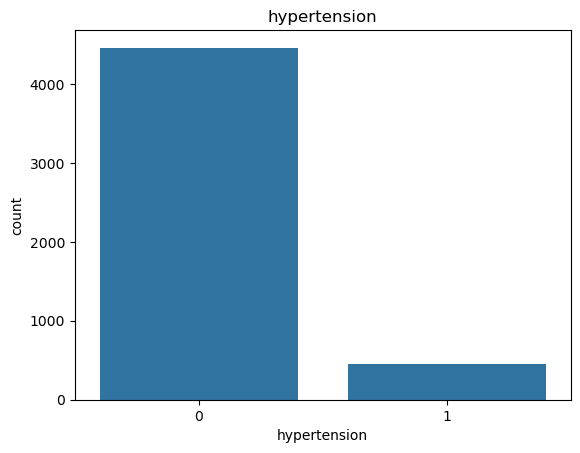

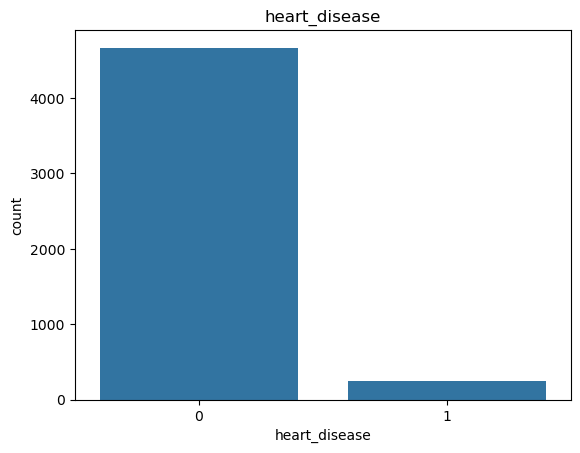

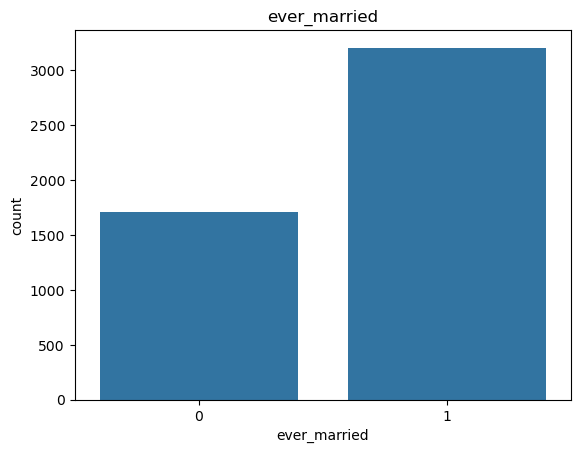

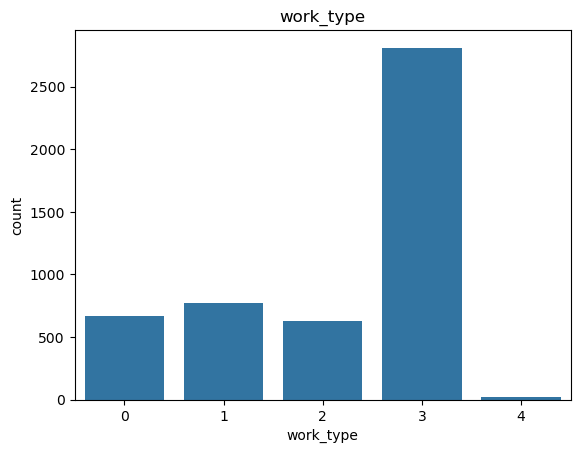

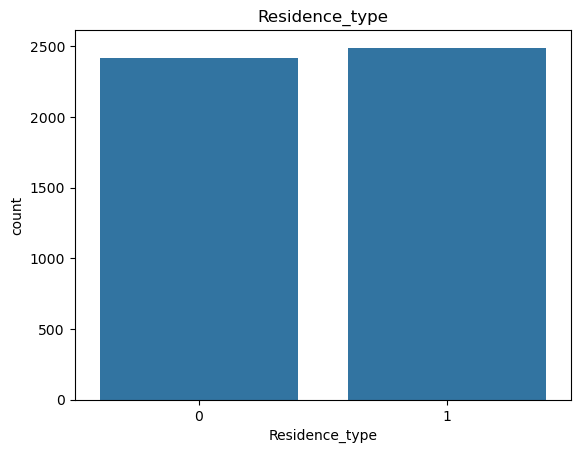

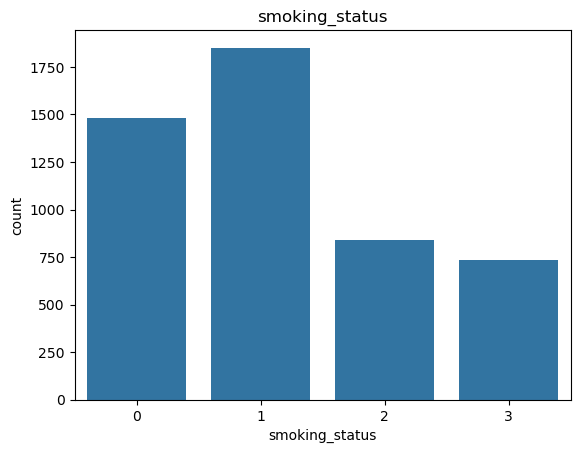

gender          0          1     2
stroke                            
0       40.831322  42.409190  26.0
1       68.348315  67.241667   NaN
hypertension          0          1
stroke                            
0             39.995154  61.214834
1             66.973154  69.550000
heart_disease          0          1
stroke                             
0              40.596202  67.551724
1              66.710059  71.950000
ever_married          0          1
stroke                            
0             21.206968  53.215374
1             66.521739  67.860215
work_type          0          1          2          3          4
stroke                                                          
0           6.867343  59.087258  50.016611  44.167660  16.181818
1          14.000000  71.207547  65.785714  67.102362        NaN
Residence_type          0          1
stroke                              
0               41.542199  41.973020
1               67.490000  67.917431
smoking_status          0   

In [18]:
pd.pivot_table(data, index='stroke', values=['age', 'avg_glucose_level', 'bmi'])

# for i in data_cat.columns:
#     sns.barplot(data_cat[i].value_counts().index,data_cat[i].value_counts()).set_title(i)
#     plt.show()

for i in data_cat.columns:
    sns.barplot(x=data_cat[i].value_counts().index, y=data_cat[i].value_counts()).set_title(i)
    plt.show()
#'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
#'age', 'avg_glucose_level', 'bmi'
print(pd.pivot_table(data,index='stroke',columns='gender', values='age'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='hypertension', values='age'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='heart_disease', values='age'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='ever_married', values='age'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='work_type', values='age'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='Residence_type', values='age'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='smoking_status', values='age'))

print(pd.pivot_table(data,index='stroke',columns='gender', values='avg_glucose_level'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='hypertension', values='avg_glucose_level'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='heart_disease', values='avg_glucose_level'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='ever_married', values='avg_glucose_level'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='work_type', values='avg_glucose_level'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='Residence_type', values='avg_glucose_level'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='smoking_status', values='avg_glucose_level'))

print(pd.pivot_table(data,index='stroke',columns='gender', values='bmi'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='hypertension', values='bmi'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='heart_disease', values='bmi'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='ever_married', values='bmi'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='work_type', values='bmi'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='Residence_type', values='bmi'))
print("="*100)
print(pd.pivot_table(data,index='stroke',columns='smoking_status', values='bmi'))

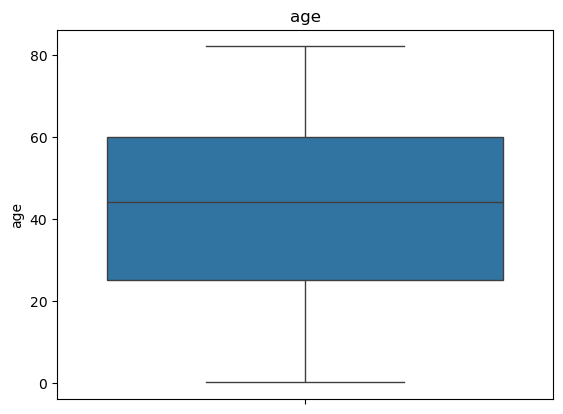

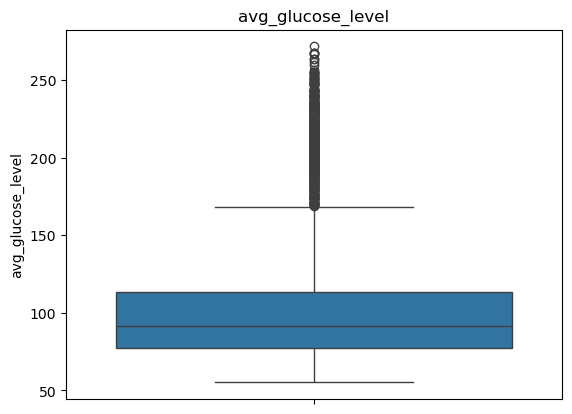

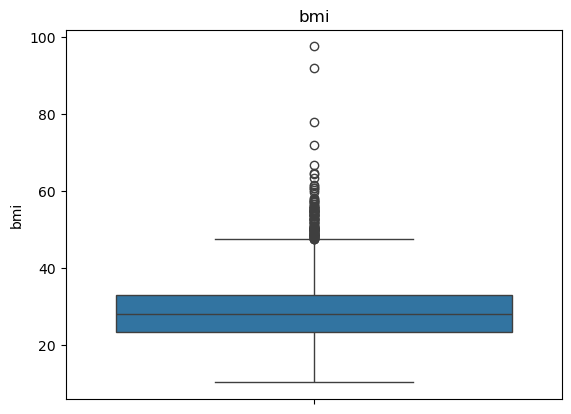

In [19]:
for i in data_num.columns:
    sns.boxplot(data_num[i])
    plt.title(i)
    plt.show()

def outlinefree(dataCol):
    # sorting column
    sorted(dataCol)
    
    # getting percentile 25 and 27 that will help us for getting IQR (interquartile range)
    Q1,Q3 = np.percentile(dataCol,[25,75])
    
    # getting IQR (interquartile range)
    IQR = Q3-Q1
    
    # getting Lower range error
    LowerRange = Q1-(1.5 * IQR)
    
    # getting upper range error
    UpperRange = Q3+(1.5 * IQR)
    
    # return Lower range and upper range.
    return LowerRange,UpperRange

Handling avg_glucose_level outliers

In [20]:
iqr = stats.iqr(data['avg_glucose_level'],interpolation='midpoint')
print("IQR",iqr)

# step:2
Q1 = data['avg_glucose_level'].quantile(0.25)  # first quantile
Q3 = data['avg_glucose_level'].quantile(0.75)  #third quantile
# getting max & min limit
min_limit = Q1 - 1.5*iqr
print('minimum limit',min_limit)
max_limit = Q3 + 1.5*iqr
print('maximum limit',max_limit)

IQR 36.5
minimum limit 22.319999999999993
maximum limit 168.32


In [21]:
data.loc[data['avg_glucose_level'] < min_limit]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [22]:
data.loc[data['avg_glucose_level'] > max_limit]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,3,1,228.69,36.6,2,1
3,1,49.0,0,0,1,3,1,171.23,34.4,3,1
4,1,79.0,1,0,1,1,0,174.12,24.0,1,1
5,0,81.0,0,0,1,3,1,186.21,29.0,2,1
14,1,79.0,0,1,1,3,1,214.09,28.2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5061,0,41.0,0,0,1,3,1,223.78,32.3,1,0
5062,1,82.0,0,0,1,1,0,211.58,36.9,1,0
5063,0,39.0,0,0,1,3,1,179.38,27.7,0,0
5064,0,70.0,0,0,1,1,0,193.88,24.3,0,0


In [23]:
# Step 2: Identify outliers
outliers = (data['avg_glucose_level'] < min_limit) | (data['avg_glucose_level'] > max_limit)

# Step 3: Drop outliers and store cleaned data back to original DataFrame
data = data[~outliers]

In [24]:
print(f"Number of rows dropped: {outliers.sum()}")

Number of rows dropped: 567


In [25]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,0,80.0,0,1,1,3,0,105.92,32.5,1,1
6,0,74.0,1,1,1,3,0,70.09,27.4,1,1
7,1,69.0,0,0,0,3,1,94.39,22.8,1,1
9,1,78.0,0,0,1,3,1,58.57,24.2,0,1
10,1,81.0,1,0,1,3,0,80.43,29.7,1,1


Handling bmi outliers

In [26]:
iqr = stats.iqr(data['bmi'],interpolation='midpoint')
print("IQR",iqr)

# step:2
Q1 = data['bmi'].quantile(0.25)  # first quantile
Q3 = data['bmi'].quantile(0.75)  #third quantile
# getting max & min limit
min_limit = Q1 - 1.5*iqr
print('minimum limit',min_limit)
max_limit = Q3 + 1.5*iqr
print('maximum limit',max_limit)

IQR 9.299999999999997
minimum limit 9.150000000000006
maximum limit 46.349999999999994


In [27]:
data.loc[data['bmi'] < min_limit]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [28]:
data.loc[data['bmi'] > max_limit]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
270,1,57.0,1,0,1,3,0,129.54,60.9,3,0
333,1,52.0,0,0,1,3,1,82.24,54.7,2,0
341,1,37.0,0,0,1,3,0,75.18,48.2,2,0
358,0,52.0,0,0,1,1,1,78.40,64.8,1,0
368,1,44.0,0,0,1,3,0,107.41,47.3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4858,1,43.0,0,0,1,3,1,100.88,47.6,3,0
4906,1,53.0,0,0,1,3,1,70.51,54.1,1,0
5009,1,50.0,0,0,1,1,0,126.85,49.5,2,0
5057,1,49.0,0,0,1,2,1,69.92,47.6,1,0


In [29]:
features = data.iloc[:,:-1].values
label = data.iloc[:,-1].values

In [30]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,0,80.0,0,1,1,3,0,105.92,32.5,1,1
6,0,74.0,1,1,1,3,0,70.09,27.4,1,1
7,1,69.0,0,0,0,3,1,94.39,22.8,1,1
9,1,78.0,0,0,1,3,1,58.57,24.2,0,1
10,1,81.0,1,0,1,3,0,80.43,29.7,1,1


In [31]:
data.shape

(4342, 11)

Logistic Regression

Test score: 0.7311233885819521 Train score: 0.7598280098280098 

True label distribution: [1057   29]
Predicted label distribution: [785 301]


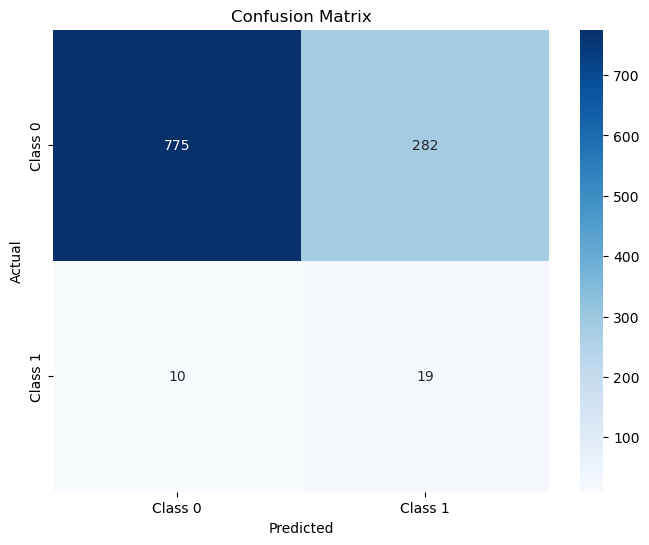

F1 score:  0.11515151515151516 

Precision score:  0.06312292358803986 

Recall score:  0.6551724137931034 

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1057
           1       0.06      0.66      0.12        29

    accuracy                           0.73      1086
   macro avg       0.53      0.69      0.48      1086
weighted avg       0.96      0.73      0.82      1086



In [32]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=102)

# Initialize the Logistic Regression model with class_weight='balanced'
classimodel = LogisticRegression(class_weight='balanced', random_state=102)

# Train the model
classimodel.fit(X_train, y_train)

# Calculate training and test scores
trainscore = classimodel.score(X_train, y_train)
testscore = classimodel.score(X_test, y_test)

print("Test score: {} Train score: {}".format(testscore, trainscore), '\n')

# Make predictions on the test set
y_pred = classimodel.predict(X_test)

# Check the distribution of the true and predicted labels
print("True label distribution:", np.bincount(y_test))
print("Predicted label distribution:", np.bincount(y_pred))

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the other metrics
f1 = f1_score(y_test, y_pred, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print('F1 score: ', f1, '\n')
print('Precision score: ', precision, '\n')
print('Recall score: ', recall, '\n')
print(classification_report(y_test, y_pred, zero_division=1))

K-Nearest Neighbor(KNN)

test score: 0.9640883977900553 train score: 1.0 



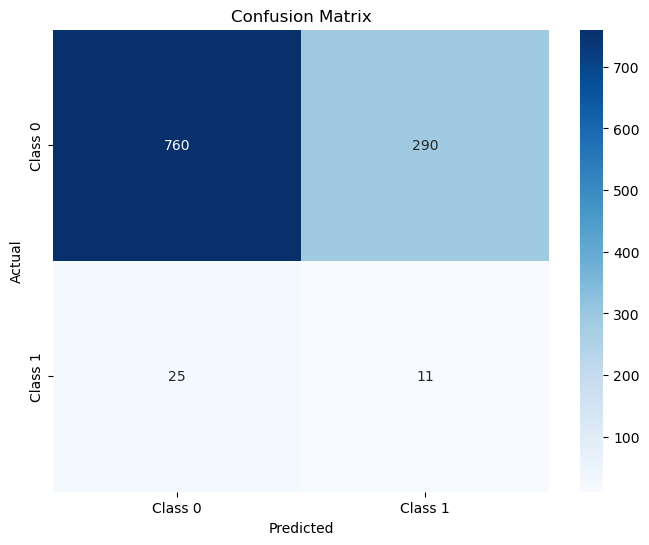

f1_score:  0.04878048780487805 

precision_score:  0.2 

recall_score:  0.027777777777777776 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1050
           1       0.20      0.03      0.05        36

    accuracy                           0.96      1086
   macro avg       0.58      0.51      0.52      1086
weighted avg       0.94      0.96      0.95      1086



In [33]:
X_train, X_test, y_train, y_test= train_test_split(features,label, test_size= 0.25, random_state=193) 


classifier= KNeighborsClassifier(weights='distance')  
knnmodel =  classifier.fit(X_train, y_train) 

trainscore =  knnmodel.score(X_train,y_train)
testscore =  knnmodel.score(X_test,y_test)  

print("test score: {} train score: {}".format(testscore,trainscore),'\n')

y_predknn =  knnmodel.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("f1_score: ",f1_score(y_test, y_predknn),'\n')
print("precision_score: ",precision_score(y_test, y_predknn),'\n')
print("recall_score: ",recall_score(y_test, y_predknn),'\n')
print(classification_report(y_test, y_predknn))

Naive bayes

test score: 0.7191528545119705 train score: 0.7806543837357052 



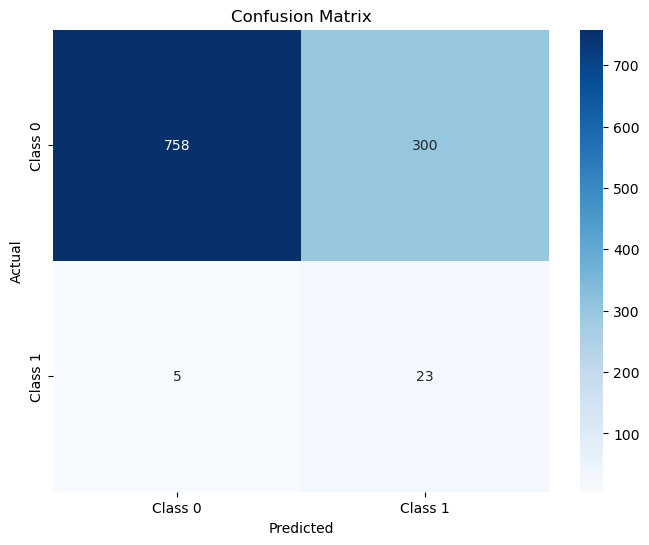

f1_score:  0.13105413105413105 

precision_score:  0.07120743034055728 

recall_score:  0.8214285714285714 

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1058
           1       0.07      0.82      0.13        28

    accuracy                           0.72      1086
   macro avg       0.53      0.77      0.48      1086
weighted avg       0.97      0.72      0.81      1086

Cross-validation scores:  [0.75396825 0.79348689 0.77760127 0.7807784  0.78554408]
Mean cross-validation score:  0.7782757794672012


In [34]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=34)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=34)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Train the GaussianNB model
NBmodel = GaussianNB()
NBmodel.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
trainscore = NBmodel.score(X_train_balanced, y_train_balanced)
testscore = NBmodel.score(X_test_scaled, y_test)

print("test score: {} train score: {}".format(testscore, trainscore), '\n')
y_predNB = NBmodel.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_predNB)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print("f1_score: ", f1_score(y_test, y_predNB), '\n')
print("precision_score: ", precision_score(y_test, y_predNB), '\n')
print("recall_score: ", recall_score(y_test, y_predNB), '\n')
print(classification_report(y_test, y_predNB))

# Cross-validation for better model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
cross_val_scores = cross_val_score(NBmodel, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
print("Cross-validation scores: ", cross_val_scores)
print("Mean cross-validation score: ", np.mean(cross_val_scores))

Support Vector Classification

In [ ]:
# X_train, X_test, y_train, y_test= train_test_split(features,label, test_size= 0.25, random_state=8) 

# svcmodel = SVC(probability=True)  
# svcmodel.fit(X_train, y_train) 

# trainscore =  svcmodel.score(X_train,y_train)
# testscore =  svcmodel.score(X_test,y_test)  

# print("test score: {} train score: {}".format(testscore,trainscore),'\n')

# y_predsvc =  svcmodel.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

# print("f1_score: ",f1_score(y_test, y_predsvc),'\n')
# print("precision_score: ",precision_score(y_test, y_predsvc),'\n')
# print("recall_score: ",recall_score(y_test, y_predsvc),'\n')
# print(classification_report(y_test, y_predsvc),'\n')

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=8)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=8)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Full parameter grid for thorough hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000, 10000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Hyperparameter tuning using GridSearchCV
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=8), n_jobs=-1)
grid.fit(X_train_balanced, y_train_balanced)

# Best model from GridSearchCV
svcmodel = grid.best_estimator_

# Evaluate the model
trainscore = svcmodel.score(X_train_balanced, y_train_balanced)
testscore = svcmodel.score(X_test_scaled, y_test)

print("Best parameters found: ", grid.best_params_)
print("test score: {} train score: {}".format(testscore, trainscore), '\n')

y_predsvc = svcmodel.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_predsvc)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print("f1_score: ", f1_score(y_test, y_predsvc), '\n')
print("precision_score: ", precision_score(y_test, y_predsvc), '\n')
print("recall_score: ", recall_score(y_test, y_predsvc), '\n')
print(classification_report(y_test, y_predsvc), '\n')

# Cross-validation for better model evaluation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)
cross_val_scores = cross_val_score(svcmodel, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
print("Cross-validation scores: ", cross_val_scores)
print("Mean cross-validation score: ", np.mean(cross_val_scores))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


Logistic Regression

In [ ]:
probabilityValues = classimodel.predict_proba(features)[:,1]
#Calculate AUC
auc = roc_auc_score(label,probabilityValues)
print(auc)
#Calculate roc_curve
fpr,tpr, threshold =  roc_curve(label,probabilityValues)
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr,tpr)

K-Nearest Neighbor(KNN)

In [ ]:
probabilityValues = knnmodel.predict_proba(features)[:,1]
#Calculate AUC
auc = roc_auc_score(label,probabilityValues)
print(auc)
#Calculate roc_curve
fpr,tpr, threshold =  roc_curve(label,probabilityValues)
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr,tpr)

Naive bayes

In [ ]:
probabilityValues = NBmodel.predict_proba(features)[:,1]
#Calculate AUC
auc = roc_auc_score(label,probabilityValues)
print(auc)
#Calculate roc_curve
fpr,tpr, threshold =  roc_curve(label,probabilityValues)
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr,tpr)

Support Vector Classification

In [ ]:
probabilityValues = svcmodel.predict_proba(features)[:,1]
#Calculate AUC
auc = roc_auc_score(label,probabilityValues)
print(auc)
#Calculate roc_curve
fpr,tpr, threshold =  roc_curve(label,probabilityValues)
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr,tpr)

XGBoost

In [ ]:
# X_train, X_test, y_train, y_test= train_test_split(features,label, test_size= 0.25, random_state=102)

# XGmodel= xgb.XGBRFClassifier()
# XGmodel.fit(X_train, y_train)
# trainscore =  XGmodel.score(X_train,y_train)
# testscore =  XGmodel.score(X_test,y_test)  

# print("test score: {} train score: {}".format(testscore,trainscore),'\n')

# y_predXG =  XGmodel.predict(X_test)

# #from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

# print("f1_score: ",f1_score(y_test, y_predXG),'\n')
# print("precision_score: ",precision_score(y_test, y_predXG),'\n')
# print("recall_score: ",recall_score(y_test, y_predXG),'\n')
# print(classification_report(y_test, y_predXG),'\n')

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=102)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=102)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Full parameter grid for thorough hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bynode': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Hyperparameter tuning using GridSearchCV with parallel processing
grid = GridSearchCV(xgb.XGBRFClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1), 
                    param_grid, refit=True, verbose=2, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=102), 
                    n_jobs=-1)
grid.fit(X_train_balanced, y_train_balanced)

# Best model from GridSearchCV
XGmodel = grid.best_estimator_

# Evaluate the model
trainscore = XGmodel.score(X_train_balanced, y_train_balanced)
testscore = XGmodel.score(X_test_scaled, y_test)

print("Best parameters found: ", grid.best_params_)
print("test score: {} train score: {}".format(testscore, trainscore), '\n')

y_predXG = XGmodel.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_predXG)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print("f1_score: ", f1_score(y_test, y_predXG), '\n')
print("precision_score: ", precision_score(y_test, y_predXG), '\n')
print("recall_score: ", recall_score(y_test, y_predXG), '\n')
print(classification_report(y_test, y_predXG), '\n')

# Cross-validation for better model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=102)
cross_val_scores = cross_val_score(XGmodel, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy', n_jobs=-1)
print("Cross-validation scores: ", cross_val_scores)
print("Mean cross-validation score: ", np.mean(cross_val_scores))

In [ ]:
probabilityValues = XGmodel.predict_proba(features)[:,1]
#Calculate AUC
auc = roc_auc_score(label,probabilityValues)
print(auc)
#Calculate roc_curve
fpr,tpr, threshold =  roc_curve(label,probabilityValues)
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr,tpr)

Model Saving

In [ ]:
with open("logismodel.pkl", "wb") as file:
    pickle.dump(classimodel, file)

In [ ]:
with open("logismodel.pkl", "rb") as f:
    try:
        data1 = pickle.load(f)
        print(data1)
    except EOFError:
        print("The file is empty or doesn't contain valid pickled data.")

In [ ]:
model = pickle.load(open("logismodel.pkl","rb")) # open model in read mode

In [ ]:
data.head()

In [ ]:
data.tail()

In [ ]:
prediction = model.predict(np.array([[0, 74.0, 1, 1, 1, 3, 0, 70.09, 27.4, 1]]).reshape(1,10))
print(prediction)

In [ ]:
prediction = model.predict(np.array([[0, 51.0, 0, 0, 1, 3, 0, 166.29, 25.6, 2]]).reshape(1,10))
print(prediction)

Trying Another model

In [ ]:
with open("knnmodel.pkl", "wb") as file:
    pickle.dump(knnmodel, file)

In [ ]:
with open("knnmodel.pkl", "rb") as f:
    try:
        data1 = pickle.load(f)
        print(data1)
    except EOFError:
        print("The file is empty or doesn't contain valid pickled data.")

In [ ]:
model = pickle.load(open("knnmodel.pkl","rb")) # open model in read mode

In [ ]:
prediction = model.predict(np.array([[0, 74.0, 1, 1, 1, 3, 0, 70.09, 27.4, 1]]).reshape(1,10))
print(prediction)

In [ ]:
prediction = model.predict(np.array([[0, 51.0, 0, 0, 1, 3, 0, 166.29, 25.6, 2]]).reshape(1,10))
print(prediction)